# Importing

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torch.optim as optim
import copy
import zipfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading Dataset

In [4]:
!unrar x "./drive/My Drive/types_data.rar" 

Streaming output truncated to the last 5000 lines.
Extracting  types_data/types_train/obl/78__F_Left_middle_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Left_ring_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Left_thumb_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Right_index_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Right_little_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Right_middle_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Right_ring_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/78__F_Right_thumb_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/79__M_Left_index_finger_Obl.BMP      55%  OK 
Extracting  types_data/types_train/obl/79__M_Left_little_finger_Obl.BMP      55%  OK 
Ex

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
trainset = torchvision.datasets.ImageFolder('./types_data/types_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./types_data/types_test',transform = transform)

In [7]:
trainset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [8]:
testset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [9]:
torch.unique(torch.tensor(trainset.targets), return_counts=True)

(tensor([0, 1, 2, 3]), tensor([2366, 2361, 2375, 2375]))

In [10]:
torch.unique(torch.tensor(testset.targets), return_counts=True)

(tensor([0, 1, 2, 3]), tensor([650, 650, 650, 650]))

In [ ]:
!ls -a './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test'

.  ..  Altered	Real


In [ ]:
!rm -r './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test/.ipynb_checkpoints'

In [11]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)

# Architectures

## Inception_v3 Architecture

In [ ]:
inception = model.inception_v3(pretrained= True)
print(inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, 4)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([4, 768])
torch.Size([4])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, 4)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([4, 768])
torch.Size([4])
torch.Size([4, 2048])
torch.Size([4])


In [ ]:
for param in inception.Conv2d_1a_3x3.parameters():
  param.requires_grad = True
for param in inception.Conv2d_2a_3x3.parameters():
  param.requires_grad = True

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([4, 768])
torch.Size([4])
torch.Size([4, 2048])
torch.Size([4])


In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
inception = inception.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(inception.parameters(), lr=0.0001)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)


Min loss 1.72
Iteration: 0, Loss: 1.72
Min loss 1.72
Min loss 1.70
Min loss 1.65
Min loss 1.62
Min loss 1.57
Min loss 1.55
Min loss 1.55
Min loss 1.54
Min loss 1.51
Min loss 1.50
Min loss 1.47
Min loss 1.44
Min loss 1.43
Min loss 1.43
Min loss 1.41
Min loss 1.40
Min loss 1.36
Min loss 1.27
Min loss 1.23
Epoch: 0/15, Test acc: 25.92, Train acc: 63.25
Iteration: 0, Loss: 1.30
Min loss 1.20
Min loss 1.18
Min loss 1.13
Min loss 1.13
Min loss 1.06
Min loss 0.99
Min loss 0.96
Min loss 0.90
Min loss 0.88
Epoch: 1/15, Test acc: 27.96, Train acc: 73.34
Iteration: 0, Loss: 1.04
Min loss 0.88
Min loss 0.86
Min loss 0.85
Min loss 0.71
Min loss 0.68
Epoch: 2/15, Test acc: 28.15, Train acc: 77.01
Iteration: 0, Loss: 0.80
Min loss 0.66
Min loss 0.64
Min loss 0.61
Min loss 0.47
Epoch: 3/15, Test acc: 29.04, Train acc: 79.13
Iteration: 0, Loss: 0.98
Epoch: 4/15, Test acc: 28.85, Train acc: 80.63
Iteration: 0, Loss: 0.76
Min loss 0.43
Epoch: 5/15, Test acc: 29.50, Train acc: 81.94
Iteration: 0, Loss: 0.

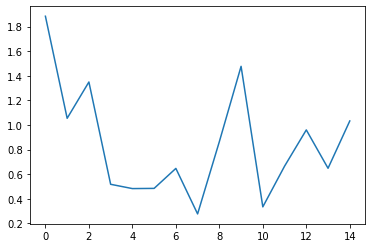

In [ ]:
loss_epoch_arr = []
max_epochs = 15

min_loss = 1000

#n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 400 == 0:
            print('Iteration: %d, Loss: %0.2f' % (i,  loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
  
    
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
    epoch, max_epochs, 
    evaluation_inception(testloader, inception), 
    evaluation_inception(trainloader, inception)))

    
plt.plot(loss_epoch_arr)
plt.show()

## AlexNet

In [12]:
alex_net = model.alexnet(pretrained=True)
print(alex_net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [13]:
for param in alex_net.parameters():
  param.requires_grad = False

  

In [14]:
in_features = alex_net.classifier[6].in_features
alex_net.classifier[6] = nn.Linear(in_features,4)

In [15]:
for param in alex_net.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([4, 4096])
torch.Size([4])


In [16]:
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
for param in alex_net.features[3:9].parameters():
  param.requires_grad = True


In [18]:
for param in alex_net.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([4, 4096])
torch.Size([4])


In [19]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [20]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


Epoch:1: Iteration 0/400: Loss: 1.472428321838379
Epoch:0/15: The Train Accuracy: 89.2687559354226 . The Test Accuracy: 77.15384615384616
Epoch:2: Iteration 0/400: Loss: 0.23492489755153656
Epoch:1/15: The Train Accuracy: 93.9326791178643 . The Test Accuracy: 84.53846153846153
Epoch:3: Iteration 0/400: Loss: 0.19607849419116974
Epoch:2/15: The Train Accuracy: 94.77682811016145 . The Test Accuracy: 82.65384615384616
Epoch:4: Iteration 0/400: Loss: 0.20336247980594635
Epoch:3/15: The Train Accuracy: 97.24596391263059 . The Test Accuracy: 87.23076923076923
Epoch:5: Iteration 0/400: Loss: 0.09227520227432251
Epoch:4/15: The Train Accuracy: 96.04305159860715 . The Test Accuracy: 86.11538461538461
Epoch:6: Iteration 0/400: Loss: 0.152278333902359
Epoch:5/15: The Train Accuracy: 98.62825788751715 . The Test Accuracy: 90.92307692307692
Epoch:7: Iteration 0/400: Loss: 0.050860073417425156
Epoch:6/15: The Train Accuracy: 98.26949456579086 . The Test Accuracy: 91.76923076923077
Epoch:8: Iteration

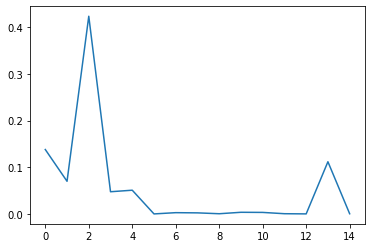

In [21]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

alex_net = alex_net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(alex_net.parameters(),lr = 0.0001,betas=(0.7,0.9))
fit(15,loss_fn,opt,alex_net)

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
y_true = testset.targets

In [24]:
len(y_true)

2600

In [25]:

def get_outputs(dataloader,model):
  
  y_pred = []
  y_true = []
  for data in dataloader:

    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    y_true.append(labels.squeeze().flatten().tolist())
    y_pred.append(pred.squeeze().flatten().tolist())

  return y_pred,y_true

In [26]:
y_pred,y_true = get_outputs(testloader,alex_net)

In [27]:
import itertools
y_pred = list(itertools.chain(*y_pred))
y_true = list(itertools.chain(*y_true))

In [28]:
print(len(y_pred),len(y_true))

2600 2600


In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       650
           1       1.00      0.99      0.99       650
           2       0.92      0.93      0.93       650
           3       0.94      0.87      0.90       650

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [31]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))


[[648   0   1   1]
 [  3 645   0   2]
 [ 12   2 606  30]
 [ 34   0  53 563]]


## VGG

In [ ]:
vgg = model.vgg16_bn(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
for param in vgg.features[3:12].parameters():
  param.requires_grad = True

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, 4)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([4, 4096])
torch.Size([4])


In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Epoch:1: Iteration 0/400: Loss: 1.399537205696106
Epoch:1: Iteration 100/400: Loss: 0.35624849796295166
Epoch:1: Iteration 200/400: Loss: 0.1795935034751892
Epoch:0/15: The Train Accuracy: 95.46269916640287 . The Test Accuracy: 54.88461538461539
Epoch:2: Iteration 0/400: Loss: 0.289610356092453
Epoch:2: Iteration 100/400: Loss: 0.09443426877260208
Epoch:2: Iteration 200/400: Loss: 0.16935116052627563
Epoch:1/15: The Train Accuracy: 96.93995990292287 . The Test Accuracy: 57.80769230769231
Epoch:3: Iteration 0/400: Loss: 0.02150852233171463
Epoch:3: Iteration 100/400: Loss: 0.12285821884870529
Epoch:3: Iteration 200/400: Loss: 0.10000758618116379
Epoch:2/15: The Train Accuracy: 98.06900918012029 . The Test Accuracy: 58.15384615384615
Epoch:4: Iteration 0/400: Loss: 0.05651841312646866
Epoch:4: Iteration 100/400: Loss: 0.02668733149766922
Epoch:4: Iteration 200/400: Loss: 0.03219986706972122
Epoch:3/15: The Train Accuracy: 98.18507966656115 . The Test Accuracy: 57.23076923076923
Epoch:5: 

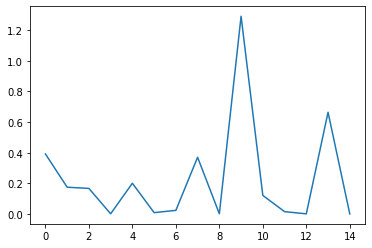

In [ ]:
vgg = vgg.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(), lr=0.0005)
fit(15,loss_fn,opt,vgg)

## ResNet-18

In [ ]:
resnet = model.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 4)

In [ ]:
for param in resnet.layer1.parameters():
  param.requires_grad = True

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([4, 512])
torch.Size([4])


In [ ]:
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch:1: Iteration 0/400: Loss: 1.442551612854004
Epoch:1: Iteration 100/400: Loss: 1.4206831455230713
Epoch:1: Iteration 200/400: Loss: 1.2740892171859741
Epoch:0/15: The Train Accuracy: 43.927403186662445 . The Test Accuracy: 26.5
Epoch:2: Iteration 0/400: Loss: 1.2771060466766357
Epoch:2: Iteration 100/400: Loss: 1.2519725561141968
Epoch:2: Iteration 200/400: Loss: 1.2189915180206299
Epoch:1/15: The Train Accuracy: 57.307164714572124 . The Test Accuracy: 26.846153846153847
Epoch:3: Iteration 0/400: Loss: 1.3067749738693237
Epoch:3: Iteration 100/400: Loss: 1.1239137649536133
Epoch:3: Iteration 200/400: Loss: 1.163986086845398
Epoch:2/15: The Train Accuracy: 66.64556294185924 . The Test Accuracy: 27.03846153846154
Epoch:4: Iteration 0/400: Loss: 1.006762981414795
Epoch:4: Iteration 100/400: Loss: 1.060232400894165
Epoch:4: Iteration 200/400: Loss: 1.102062702178955
Epoch:3/15: The Train Accuracy: 73.07164714572122 . The Test Accuracy: 27.346153846153847
Epoch:5: Iteration 0/400: Loss

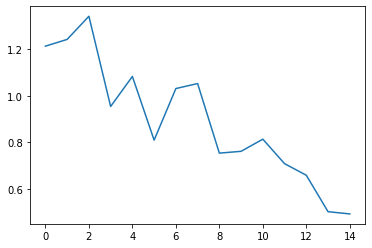

In [ ]:
resnet = resnet.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.00001)
fit(15,loss_fn,opt,resnet)

# MobileNet

In [ ]:
mobilenet = model.mobilenet_v2(pretrained = True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
for param in mobilenet.parameters():
  param.requires_grad = False

  

In [ ]:
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features,4)

In [ ]:
for param in mobilenet.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([4, 1280])
torch.Size([4])


In [ ]:
for param in mobilenet.features[0:2].parameters():
  param.requires_grad = True


In [ ]:
for param in mobilenet.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([4, 1280])
torch.Size([4])


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


Epoch:1: Iteration 0/400: Loss: 1.4563606977462769
Epoch:1: Iteration 100/400: Loss: 0.747644305229187
Epoch:0/15: The Train Accuracy: 83.03260525482747 . The Test Accuracy: 27.03846153846154
Epoch:2: Iteration 0/400: Loss: 0.496809184551239
Epoch:2: Iteration 100/400: Loss: 0.2852305471897125
Epoch:1/15: The Train Accuracy: 85.10077028595548 . The Test Accuracy: 31.653846153846153
Epoch:3: Iteration 0/400: Loss: 0.41502201557159424
Epoch:3: Iteration 100/400: Loss: 0.18390795588493347
Epoch:2/15: The Train Accuracy: 86.43030494882346 . The Test Accuracy: 28.76923076923077
Epoch:4: Iteration 0/400: Loss: 0.49406370520591736
Epoch:4: Iteration 100/400: Loss: 0.3205210864543915
Epoch:3/15: The Train Accuracy: 90.78822412155745 . The Test Accuracy: 31.076923076923077
Epoch:5: Iteration 0/400: Loss: 0.32523682713508606
Epoch:5: Iteration 100/400: Loss: 0.3050938546657562
Epoch:4/15: The Train Accuracy: 89.01551123773346 . The Test Accuracy: 32.11538461538461
Epoch:6: Iteration 0/400: Loss:

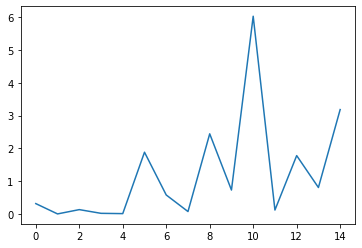

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

mobilenet = mobilenet.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(mobilenet.parameters(),lr = 0.01)
fit(15,loss_fn,opt,mobilenet)

# AkaNet

In [ ]:
class AkaNet(nn.Module):
  
  def __init__(self):
    
    super(AkaNet,self).__init__()

    self.model_cnn = nn.Sequential(
        nn.Conv2d(3,6,3), #(N,1,224,224) --> (N,6,222,222)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,6,222,222) -->(N,6,111,111)
        nn.Conv2d(6,16,5), #(N,6,111,111)  --> (N,16,107,107)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,16,107,107) --> (N,16,53,53)
        
    )

    self.model_fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(44944,120),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(120,60),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(60,20),
        nn.ReLU(),
        nn.Linear(20,4) 
    )

  def forward(self,x):
    x = self.model_cnn(x)
    x = x.view(x.size(0),-1)
    x = self.model_fc(x)
    return x


In [ ]:
net = AkaNet()

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
trainset = torchvision.datasets.ImageFolder('./types_data/types_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./types_data/types_test',transform = transform)

In [ ]:
trainset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [ ]:
testset.class_to_idx

{'cr': 0, 'obl': 1, 'real': 2, 'zcut': 3}

In [ ]:
net = AkaNet()


Epoch:1: Iteration 0/400: Loss: 0.9727107882499695
Epoch:0/20: The Train Accuracy: 47.24068798142872 . The Test Accuracy: 50.0
Epoch:2: Iteration 0/400: Loss: 1.0033795833587646
Epoch:1/20: The Train Accuracy: 64.46132742429039 . The Test Accuracy: 61.34615384615385
Epoch:3: Iteration 0/400: Loss: 0.7222885489463806
Epoch:2/20: The Train Accuracy: 69.1358024691358 . The Test Accuracy: 70.61538461538461
Epoch:4: Iteration 0/400: Loss: 0.6153252124786377
Epoch:3/20: The Train Accuracy: 77.21852907038092 . The Test Accuracy: 73.57692307692308
Epoch:5: Iteration 0/400: Loss: 0.5251808762550354
Epoch:4/20: The Train Accuracy: 42.46069431254617 . The Test Accuracy: 49.53846153846154
Epoch:6: Iteration 0/400: Loss: 18.052902221679688
Epoch:5/20: The Train Accuracy: 73.98965917484436 . The Test Accuracy: 68.15384615384616
Epoch:7: Iteration 0/400: Loss: 0.564719557762146
Epoch:6/20: The Train Accuracy: 84.06668777039147 . The Test Accuracy: 74.34615384615384
Epoch:8: Iteration 0/400: Loss: 0.4

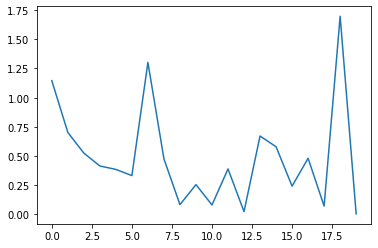

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

net = net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr=0.01,betas=(0.7,0.9))
fit(20,loss_fn,opt,net)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_true = testset.targets

In [ ]:
len(y_true)

2600

In [ ]:

def get_outputs(dataloader,model):
  
  y_pred = []
  y_true = []
  for data in dataloader:

    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    y_true.append(labels.squeeze().flatten().tolist())
    y_pred.append(pred.squeeze().flatten().tolist())

  return y_pred,y_true

In [ ]:
y_pred,y_true = get_outputs(testloader,resnet)

In [ ]:
import itertools
y_pred = list(itertools.chain(*y_pred))
y_true = list(itertools.chain(*y_true))


In [ ]:
print(len(y_pred),len(y_true))

2600 2600


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.26      0.41      0.32       650
           1       0.38      0.28      0.32       650
           2       0.33      0.25      0.28       650
           3       0.30      0.28      0.29       650

    accuracy                           0.31      2600
   macro avg       0.32      0.31      0.31      2600
weighted avg       0.32      0.31      0.31      2600



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))